# Image Segmentation with Camvid


## Project Setup

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import * 
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00360.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f02250.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_008760.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_008040_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f03630_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_05640_P.png')]

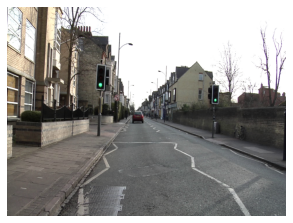

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

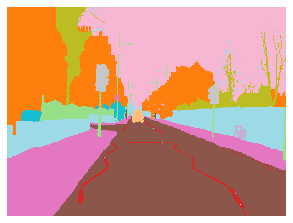

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          [ 4,  4,  4,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [0]:
size = src_size//2
bs = 8

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

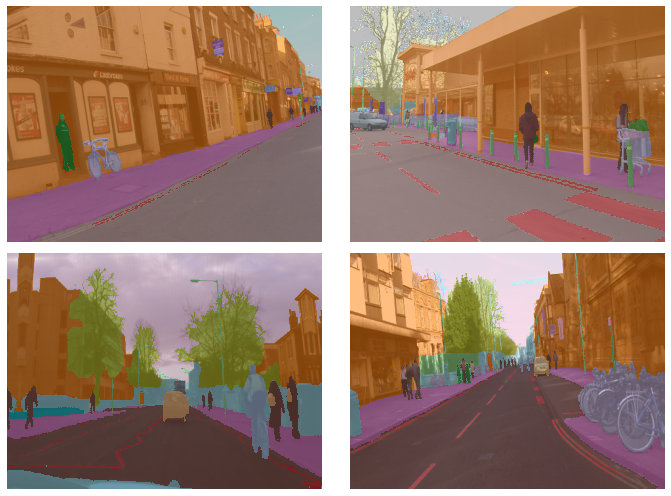

In [24]:
data.show_batch(2, figsize=(10,7))

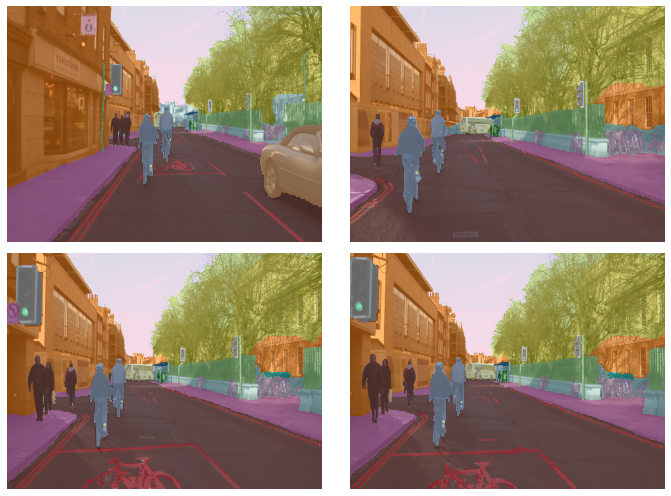

In [25]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics = acc_camvid

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


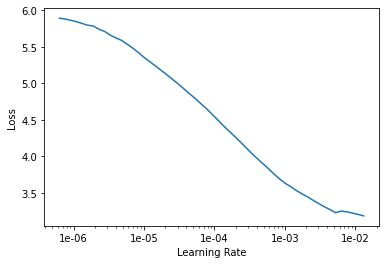

In [29]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=5e-4

In [31]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.942104,1.415973,0.666531,03:13
1,1.176419,0.830825,0.806464,03:07
2,0.870951,0.653701,0.832081,03:06
3,0.716145,0.599587,0.838032,03:07
4,0.665326,0.565249,0.843307,03:07
5,0.571749,0.461033,0.869294,03:06
6,0.536575,0.501167,0.861721,03:06
7,0.534023,0.408900,0.887906,03:05
8,0.489473,0.361383,0.892732,03:05
9,0.427110,0.309551,0.910995,03:06


In [0]:
learn.save('stage-1')

In [33]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

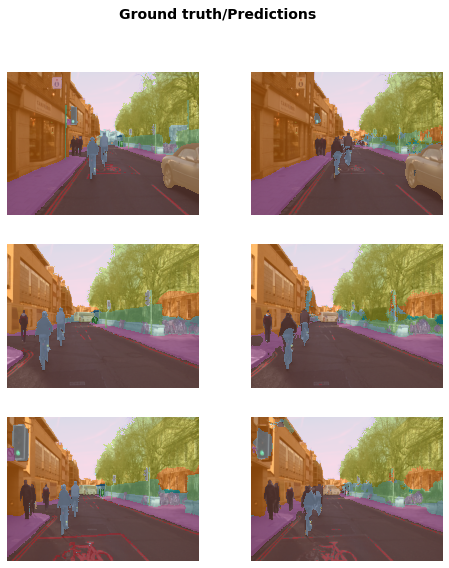

In [34]:
learn.show_results(rows=3, figsize=(8,9))

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [37]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.367666,0.307079,0.910888,03:13
1,0.363812,0.308008,0.909342,03:13
2,0.353093,0.304021,0.911117,03:13
3,0.343962,0.304100,0.910457,03:13
4,0.338366,0.289163,0.919467,03:13
5,0.330919,0.297213,0.915085,03:14
6,0.323923,0.302982,0.913308,03:14
7,0.315503,0.319205,0.907448,03:13
8,0.311402,0.296531,0.911535,03:13
9,0.296441,0.294585,0.914696,03:14


In [0]:
learn.save('stage-2')

## Going big

In [0]:

size = src_size
bs = 2

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


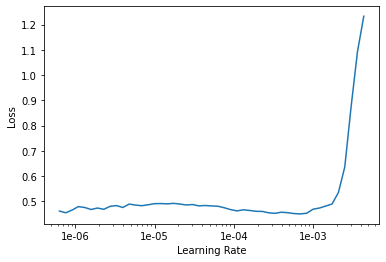

In [43]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr = 1e-5

In [45]:
learn.fit_one_cycle(5, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.456106,0.339718,0.906358,13:40
1,0.404875,0.311498,0.913233,13:46
2,0.365907,0.307463,0.914615,13:35
3,0.348693,0.300395,0.915030,13:36
4,0.346004,0.293953,0.918521,13:45


In [0]:
learn.save('stage-1-big')


In [0]:
learn.load('stage-1-big');


epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


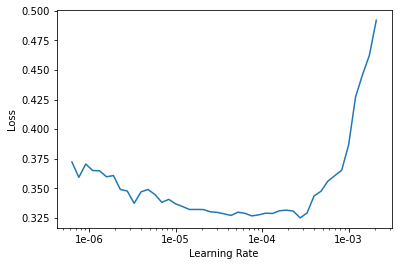

In [48]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lrs = slice(1e-6, 2e-5)

In [50]:
learn.fit_one_cycle(10, lrs)


epoch,train_loss,valid_loss,acc_camvid,time
0,0.327318,0.306394,0.914957,13:36
1,0.342877,0.290997,0.919332,13:45
2,0.329781,0.295107,0.916689,13:45
3,0.325329,0.300447,0.913508,13:37
4,0.314307,0.286869,0.920321,13:35
5,0.290418,0.273918,0.923746,13:45
6,0.283476,0.277720,0.923312,13:45
7,0.288703,0.277582,0.922619,13:35
8,0.269033,0.272391,0.924325,13:37
9,0.293648,0.268065,0.925010,13:45
